### imports

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

### train.csv

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_file_path = '/content/drive/My Drive/HMS/train.csv'

In [5]:
df = pd.read_csv(train_file_path)

In [6]:
df.shape

(106800, 15)

In [7]:
df.columns

Index(['eeg_id', 'eeg_sub_id', 'eeg_label_offset_seconds', 'spectrogram_id',
       'spectrogram_sub_id', 'spectrogram_label_offset_seconds', 'label_id',
       'patient_id', 'expert_consensus', 'seizure_vote', 'lpd_vote',
       'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'],
      dtype='object')

In [8]:
df['expert_consensus'].value_counts()

Seizure    20933
GRDA       18861
Other      18808
GPD        16702
LRDA       16640
LPD        14856
Name: expert_consensus, dtype: int64

In [9]:
filtered_df = df[df['spectrogram_sub_id'] == 0]
value_counts = filtered_df['expert_consensus'].value_counts()
print(value_counts)

Other      4699
Seizure    2045
GRDA       1422
LPD        1284
GPD        1025
LRDA        663
Name: expert_consensus, dtype: int64


### train.pqt

In [10]:
train_pqt_file_path = '/content/drive/My Drive/HMS/train.pqt'

In [11]:
df_pqt = pd.read_parquet(train_pqt_file_path, engine='pyarrow')

In [12]:
df_pqt.shape

(17089, 412)

In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_pqt['target_encoded'] = le.fit_transform(df_pqt['target'])

In [14]:
le.classes_ # [0,1,2,3,4,5] - target class equivalent by order

array(['GPD', 'GRDA', 'LPD', 'LRDA', 'Other', 'Seizure'], dtype=object)

### df_split - making splitting next to target

In [15]:
sampled_df = pd.DataFrame()
sampled_spec_ids = set()

for target_class in range(len(le.classes_)):
    available_df = df_pqt[(df_pqt['target_encoded'] == target_class) & (~df_pqt['spec_id'].isin(sampled_spec_ids))]
    n_samples = min(500, len(available_df))
    class_sample = available_df.sample(n=n_samples, random_state=42)
    sampled_df = pd.concat([sampled_df, class_sample])
    sampled_spec_ids.update(class_sample['spec_id'].tolist())

df_split = sampled_df[['spec_id', 'target_encoded']]

print("Sampled DataFrame shape:", df_split.shape)
print("Sample distribution:\n", df_split['target_encoded'].value_counts())
unique_spec_ids_in_split = df_split['spec_id'].nunique()
print("Unique spec_id values in df_split:", unique_spec_ids_in_split)

Sampled DataFrame shape: (3000, 2)
Sample distribution:
 0    500
1    500
2    500
3    500
4    500
5    500
Name: target_encoded, dtype: int64
Unique spec_id values in df_split: 2658


In [16]:
df_split[df_split.duplicated()]

,spec_id,target_encoded
5264,1455661633,0
9691,1455661633,0
1891,1643788791,0
12525,1908433744,0
4822,1696913949,0
...,...,...
8400,1213451719,5
16199,472382305,5
5201,1224345407,5
8189,59665103,5


In [17]:
df_split = df_split.drop_duplicates()

In [18]:
df_split[df_split.duplicated()]

,spec_id,target_encoded


In [19]:
df_split.shape

(2658, 2)

### specs.npy

In [20]:
def load_spectrograms(path, read_spec_files=False):

    if read_spec_files:
        spectrograms = {}
        for i,f in enumerate(files):
            if i%100==0: print(i,', ',end='')
            tmp = pd.read_parquet(f'{path}//{f}')
            name = int(f.split('.')[0])
            spectrograms[name] = tmp.iloc[:,1:].values
    else:
        spectrograms = np.load(f"{path}", allow_pickle=True).item()
    return spectrograms

In [21]:
def get_column_names():
    columns = []
    regions = ['LL_', 'RL_', 'LP_', 'RP_']
    increments = [
        0.59, 0.78, 0.98, 1.17, 1.37, 1.56, 1.76, 1.95, 2.15, 2.34,
        2.54, 2.73, 2.93, 3.13, 3.32, 3.52, 3.71, 3.91, 4.1, 4.3,
        4.49, 4.69, 4.88, 5.08, 5.27, 5.47, 5.66, 5.86, 6.05, 6.25,
        6.45, 6.64, 6.84, 7.03, 7.23, 7.42, 7.62, 7.81, 8.01, 8.2,
        8.4, 8.59, 8.79, 8.98, 9.18, 9.38, 9.57, 9.77, 9.96, 10.16,
        10.35, 10.55, 10.74, 10.94, 11.13, 11.33, 11.52, 11.72, 11.91,
        12.11, 12.3, 12.5, 12.7, 12.89, 13.09, 13.28, 13.48, 13.67,
        13.87, 14.06, 14.26, 14.45, 14.65, 14.84, 15.04, 15.23, 15.43,
        15.63, 15.82, 16.02, 16.21, 16.41, 16.6, 16.8, 16.99, 17.19,
        17.38, 17.58, 17.77, 17.97, 18.16, 18.36, 18.55, 18.75, 18.95,
        19.14, 19.34, 19.53, 19.73, 19.92
    ]

    for r in regions:
        for i in increments:
            columns.extend([f'{r}{i}'])
    return columns

In [22]:
def get_spect_df(spectrograms):
    columns = get_column_names()
    dataframes = {}
    for key in spectrograms:
        subset_array = spectrograms[key][:300]
        df = pd.DataFrame(subset_array, columns=columns)
        dataframes[key] = df
    return dataframes

In [23]:
PATH = r'/content/drive/My Drive/HMS/specs.npy'
spectrograms = load_spectrograms(PATH)
dataframes = get_spect_df(spectrograms)

### sub_dataframes - partial of the dataframes

In [24]:
relevant_spec_ids = df_split['spec_id'].unique()
sub_dataframes = {key: dataframes[key] for key in relevant_spec_ids if key in dataframes}
print("Number of original DataFrames:", len(dataframes))
print("Number of filtered DataFrames:", len(sub_dataframes))

Number of original DataFrames: 11138
Number of filtered DataFrames: 2658


### train-test-split

In [25]:
df_train, df_test = train_test_split(df_split, test_size=0.2, stratify=df_split['target_encoded'], random_state=42)

In [26]:
df_train.shape,df_test.shape

((2126, 2), (532, 2))

In [27]:
X = df_split.drop('target_encoded', axis=1)
y = df_split['target_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2126, 1), (532, 1), (2126,), (532,))

In [28]:
train_sub_dataframes = {spec_id: sub_dataframes[spec_id] for spec_id in df_train['spec_id']}
test_sub_dataframes = {spec_id: sub_dataframes[spec_id] for spec_id in df_test['spec_id']}


In [29]:
len(train_sub_dataframes.keys()),len(test_sub_dataframes.keys())

(2126, 532)

### preprocessing

In [30]:
def process_dataframe(df, selected_columns, fit=False):
    """
    Process a single dataframe to remove rows with NaNs, select specific columns,
    and generate desired features: standard deviation, one-time step lag, and
    3-time step rolling window.
    """
    df_clean = df.dropna()

    segments = np.array_split(df_clean, 3)

    features = []

    for segment in segments:
        for col in selected_columns:
            std_dev = segment[col].std()
            features.append(std_dev)

            lag_1 = segment[col].shift(1).fillna(method='bfill')
            features.append(lag_1.iloc[-1])

            rolling_3 = segment[col].rolling(window=3).mean().fillna(method='bfill')
            features.append(rolling_3.iloc[-1])

    return np.array(features).reshape(1, -1)


full_column_names = get_column_names()
selected_columns = [full_column_names[i] for i in [49, 99, 149, 199, 249, 299, 349, 399]]

In [31]:
def transform_dictionaries(sub_dataframes, selected_columns):
    transformed_data = {}
    for spec_id, df in sub_dataframes.items():
        transformed_data[spec_id] = process_dataframe(df, selected_columns)
    return transformed_data

train_transformed = transform_dictionaries(train_sub_dataframes, selected_columns)
test_transformed = transform_dictionaries(test_sub_dataframes, selected_columns)


In [32]:
train_rows = [(spec_id, *features.ravel()) for spec_id, features in train_transformed.items()]
train_df = pd.DataFrame(train_rows, columns=['spec_id'] + [f'feature_{i}' for i in range(1, 73)])

test_rows = [(spec_id, *features.ravel()) for spec_id, features in test_transformed.items()]
test_df = pd.DataFrame(test_rows, columns=['spec_id'] + [f'feature_{i}' for i in range(1, 73)])

In [33]:
train_df_with_target = train_df.merge(df_train[['spec_id', 'target_encoded']], on='spec_id')

test_df_with_target = test_df.merge(df_test[['spec_id', 'target_encoded']], on='spec_id')

In [34]:
assert len(train_df_with_target) == len(df_train), "Row counts do not match!"


In [35]:
assert set(train_df_with_target['spec_id']) == set(df_train['spec_id']), "Spec_id values do not match!"


In [36]:
assert not train_df_with_target['target_encoded'].isnull().any(), "NaN values found in target_encoded!"


In [37]:
assert len(test_df_with_target) == len(df_test), "Row counts do not match!"


In [38]:
assert set(test_df_with_target['spec_id']) == set(df_test['spec_id']), "Spec_id values do not match!"


In [39]:
assert not test_df_with_target['target_encoded'].isnull().any(), "NaN values found in target_encoded!"


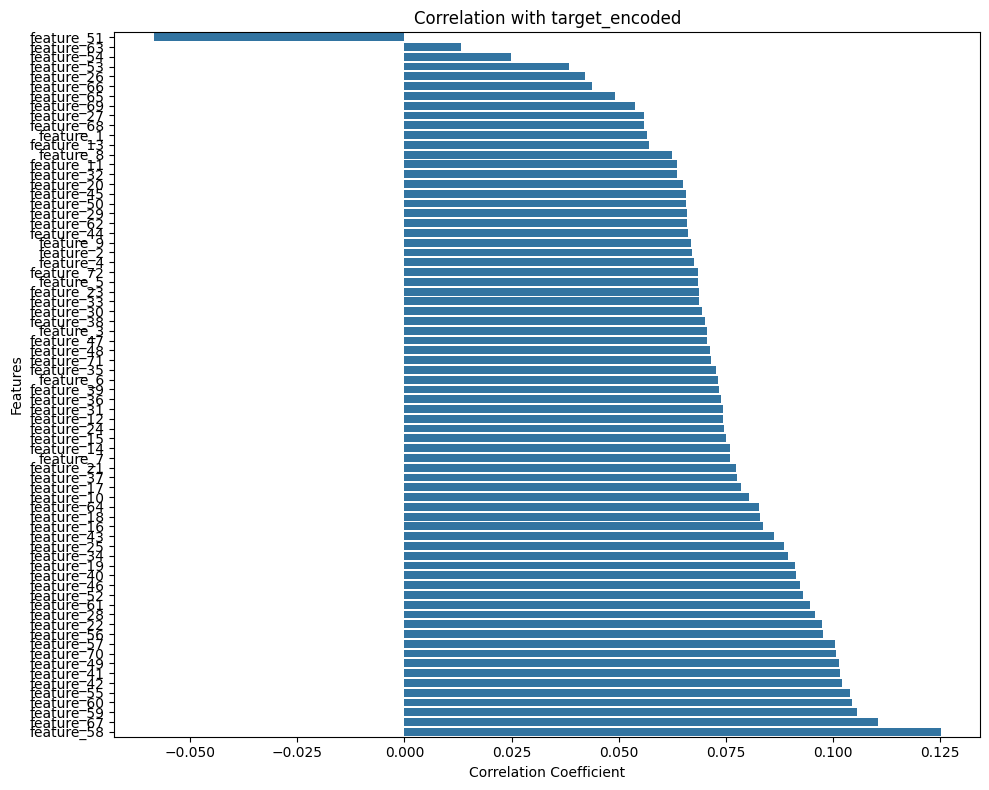

In [40]:
# correlations
def plot_correlations(df, target_variables):
    for target_variable in target_variables:
        df_copy = df.copy()
        df_copy = df_copy.drop(['spec_id'], axis=1)
        correlations = df_copy.corr().drop(index=target_variables, columns=target_variables)
        corr_with_target = df_copy.corr()[target_variable].drop(target_variable)

        corr_df = corr_with_target.sort_values().reset_index()
        corr_df.columns = ['Feature', 'Correlation']

        plt.figure(figsize=(10, 8))
        sns.barplot(x='Correlation', y='Feature', data=corr_df, orient='h')
        plt.title(f'Correlation with {target_variable}')
        plt.xlabel('Correlation Coefficient')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()
target_variables = ['target_encoded']
plot_correlations(test_df_with_target, target_variables)

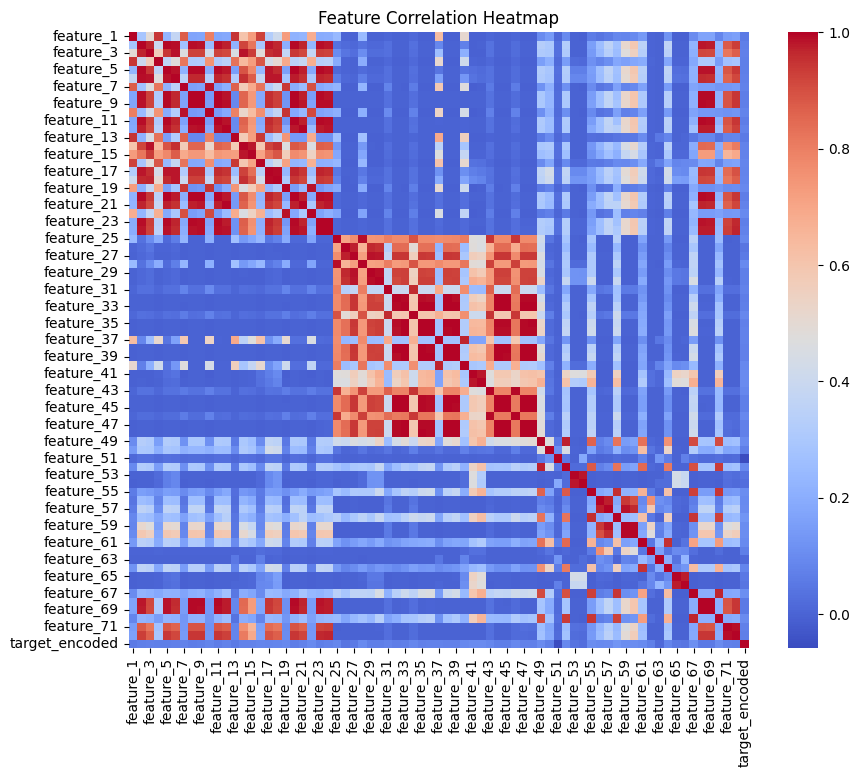

In [41]:
# heatmap
df_copy2 = test_df_with_target.copy()
df_copy2 = df_copy2.drop(['spec_id'], axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(df_copy2.corr(), annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

In [42]:
train_to_model = train_df_with_target.drop(['target_encoded', 'spec_id'], axis=1)

In [43]:
train_to_model.shape

(2126, 72)

In [44]:
train_to_model.columns

Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10',
       'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20',
       'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25',
       'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30',
       'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35',
       'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40',
       'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45',
       'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50',
       'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55',
       'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60',
       'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65',
       '

In [45]:
test_to_model = test_df_with_target.drop(['target_encoded', 'spec_id'], axis=1)

In [46]:
test_to_model.shape

(532, 72)

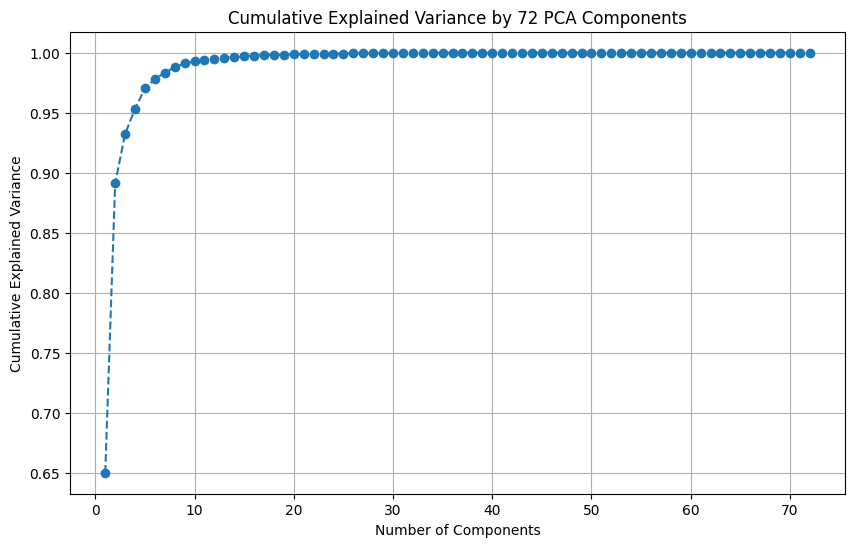

Explained variance ratio per component:
Component 1: 65.0285%
Component 2: 24.0919%
Component 3: 4.1163%
Component 4: 2.0962%
Component 5: 1.7014%
Component 6: 0.7776%
Component 7: 0.5346%
Component 8: 0.4407%
Component 9: 0.3336%
Component 10: 0.1501%
Component 11: 0.1215%
Component 12: 0.1010%
Component 13: 0.0812%
Component 14: 0.0703%
Component 15: 0.0572%
Component 16: 0.0424%
Component 17: 0.0361%
Component 18: 0.0277%
Component 19: 0.0269%
Component 20: 0.0218%
Component 21: 0.0187%
Component 22: 0.0172%
Component 23: 0.0158%
Component 24: 0.0136%
Component 25: 0.0110%
Component 26: 0.0095%
Component 27: 0.0089%
Component 28: 0.0073%
Component 29: 0.0070%
Component 30: 0.0049%
Component 31: 0.0043%
Component 32: 0.0038%
Component 33: 0.0032%
Component 34: 0.0029%
Component 35: 0.0024%
Component 36: 0.0021%
Component 37: 0.0018%
Component 38: 0.0016%
Component 39: 0.0014%
Component 40: 0.0009%
Component 41: 0.0006%
Component 42: 0.0005%
Component 43: 0.0005%
Component 44: 0.0004%

In [47]:
# visualise all copmponents

from sklearn.decomposition import PCA
n_components = 72

pca = PCA(n_components=n_components)
pca.fit(train_to_model)
pca_components = pca.transform(train_to_model)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by 72 PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

print("Explained variance ratio per component:")
for i, variance in enumerate(explained_variance_ratio, start=1):
    variance_in_percentage = variance * 100
    print(f"Component {i}: {variance_in_percentage:.4f}%")
cumulative_explained_variance *= 100
print(f"\nCumulative explained variance by {n_components} components: {cumulative_explained_variance[-1]:.4f}%")

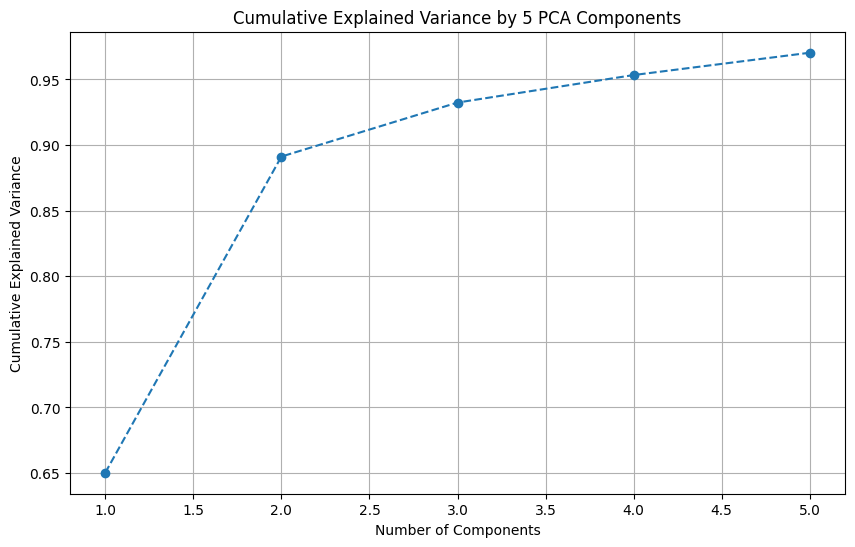

Explained variance ratio per component:
Component 1: 65.0285%
Component 2: 24.0919%
Component 3: 4.1163%
Component 4: 2.0962%
Component 5: 1.7014%

Cumulative explained variance by 5 components: 97.0343%


In [48]:
# visualise only 5  copmponents

from sklearn.decomposition import PCA
n_components = 5

pca = PCA(n_components=n_components)
pca.fit(train_to_model)
pca_components = pca.transform(train_to_model)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by 5 PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

print("Explained variance ratio per component:")
for i, variance in enumerate(explained_variance_ratio, start=1):
    variance_in_percentage = variance * 100
    print(f"Component {i}: {variance_in_percentage:.4f}%")
cumulative_explained_variance *= 100
print(f"\nCumulative explained variance by {n_components} components: {cumulative_explained_variance[-1]:.4f}%")

In [49]:
pca_test_components = pca.transform(test_to_model)


In [50]:
X_train_selected_pca = pca_components
X_test_selected_pca = pca_test_components

In [56]:
rf_classifier_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_pca.fit(X_train_selected_pca, y_train)
y_pred_pca = rf_classifier_pca.predict(X_test_selected_pca)

accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy with PCA components: {accuracy_pca}")

report_pca = classification_report(y_test, y_pred_pca)
print("Classification Report with PCA components:\n", report_pca)

Accuracy with PCA components: 0.16165413533834586
Classification Report with PCA components:
               precision    recall  f1-score   support

           0       0.14      0.14      0.14        74
           1       0.20      0.15      0.17       105
           2       0.11      0.08      0.09        73
           3       0.19      0.20      0.19        95
           4       0.19      0.24      0.21        96
           5       0.12      0.13      0.13        89

    accuracy                           0.16       532
   macro avg       0.16      0.16      0.16       532
weighted avg       0.16      0.16      0.16       532



**2658 samples:**<br>
Accuracy with PCA components: 0.16165413533834586<br>
Classification Report with PCA components:<br>
               precision    recall  f1-score   support

           0       0.14      0.14      0.14        74
           1       0.20      0.15      0.17       105
           2       0.11      0.08      0.09        73
           3       0.19      0.20      0.19        95
           4       0.19      0.24      0.21        96
           5       0.12      0.13      0.13        89

    accuracy                           0.16       532
   macro avg       0.16      0.16      0.16       532
weighted avg       0.16      0.16      0.16       532

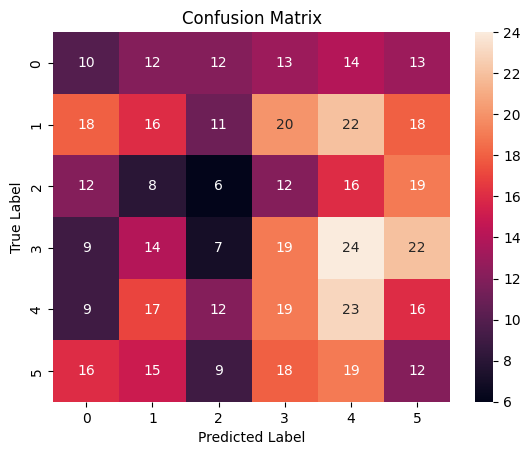

In [57]:
conf_matrix = confusion_matrix(y_test, y_pred_pca)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### top features

In [68]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_to_model, y_train)

RandomForestClassifier(random_state=42)

In [72]:
importances = rf_classifier.feature_importances_

feature_importances = pd.DataFrame(importances, index=train_to_model.columns, columns=["Importance"])

feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

top_features = feature_importances.head(5).index

X_train_selected = train_to_model[top_features]
X_test_selected = test_to_model[top_features]

In [73]:
print(top_features)

Index(['feature_10', 'feature_58', 'feature_64', 'feature_40', 'feature_4'], dtype='object')
